<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/banner.png" alt="Deparatemento de Ingeniería de Sistemas y Computación, Universidad de los Andes">

#  Aplicación de algoritmos para  el análisis de coberturas

**Introducción**

La teledetección es el proceso de **detectar** y **monitorear** las características físicas, químicas y biológicas de la cobertura terrestre. Estas caracteristicas pueden ser estudiadas mediante el análisis de la radiación reflejada y emitida a distancia por los diferentes tipos de coberturas que reposan sobre la superficie terrestre. En el presente notebook se muestran algúnos algoritmos (índices de vegetación) empleados de forma recurrente en la literatura para el estudio de cultivos. Así mismo se muestran algoritmos que permiten mitigar el efecto de las nuebes que producen valores inválidos para el análisis de un cultivo. Finalmente, se presenta la aplicación de un modelo de inteligencia artificial que permite la detección de caña para un polígono dado.

**Contenido**

1. Importar librerías
2. Consulta del área de estudio
3. Clasificar el área consultada

## 1. Importar librerías

En esta sección se importan las librerías cuya funicionalidades particulares son requeridas.

In [51]:
# las funcionalidades del open data cube son accedidas 
# por medio de la librería datacube
import datacube

# Librería usada para la carga de polígonos
import geopandas as gpd
import pandas as pd

# Librería usada para visualización de datos
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import numpy as np

# Librería para la carga del modelo de machine learning
import joblib

# Desactiva los warnings en el notebook
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Configuración de Drivers para leer polígonos en formato KMLs
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

## 2. Consulta del área de estudio

(Opción 1) Consultar un área a partir de un polígono

(10642649.20832963, 10644733.251327563)
(-7712.7293818792095, -5488.858233851031)


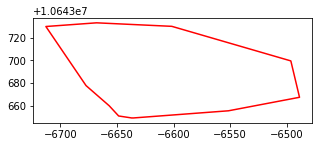

In [171]:
# Carga del archivo .kml
# df_polygon = gpd.read_file("1.kml",driver='KML') #Caña
# df_polygon = gpd.read_file("arboles.kml",driver='KML') #Arboles
# df_polygon = gpd.read_file("yuca.kml",driver='KML') #Yuca
df_polygon = gpd.read_file("maiz.kml",driver='KML') #maiz
df_polygon = df_polygon.to_crs('EPSG:32719')

# Pintar el polígono seleccionado
fig, ax = plt.subplots(figsize=(5,5))
df_polygon.boundary.plot(ax=ax,color='red')

# Obtención de la geometría del polígono del GeoDataFrame
geometry_predio = df_polygon['geometry'][0]

# Obtención de los límites del cuadrado que enmarca el polígono
minx, miny, maxx, maxy = geometry_predio.bounds

# Aumento del aŕea del cuadrado para "EPSG:4326"
# 2 kilómetros
buffer = 1000

minx = minx - buffer
miny = miny - buffer
maxx = maxx + buffer
maxy = maxy + buffer

# Parámetros de área a ser consultada
set_study_area_lat = (miny,maxy)
set_study_area_lon = (minx,maxx)

print(set_study_area_lat)
print(set_study_area_lon)

(Opción 2) Consultar un área a partir de un punto

In [172]:
# # Definición de las coordenadas del punto
# central_lat = 5.55215
# central_lon = -72.93944

# # Aumento del aŕea del cuadrado para "EPSG:4326"
# buffer = 0.1

# # Calculo del cuadro delimitador (bounding box) para el área de estudio
# set_study_area_lat = (central_lat - buffer, central_lat + buffer)
# set_study_area_lon = (central_lon - buffer, central_lon + buffer)

# print(set_study_area_lat)
# print(set_study_area_lon)

#### Carga de información en el Open Data Cube

In [173]:
dc = datacube.Datacube(app="Cana")

dataset = dc.load(
    product="s2_sen2cor_ard_granule_EO3",
    longitude=set_study_area_lon,
    latitude=set_study_area_lat,
    time=('2020-07-30', '2020-08-01'),
    measurements=["coastal_aerosol", "red", "blue", "green", "nir", "narrow_nir", "water_vapour", "veg5", "veg6", "veg7", "swir1","swir2","scl"],
    crs="EPSG:32719",
    output_crs="EPSG:32719",
    resolution=(-10, 10)
)

dataset

<xarray.Dataset>
Dimensions:          (time: 1, x: 224, y: 209)
Coordinates:
  * time             (time) datetime64[ns] 2020-08-01T20:56:40
  * y                (y) float64 1.064e+07 1.064e+07 ... 1.064e+07 1.064e+07
  * x                (x) float64 -7.715e+03 -7.705e+03 ... -5.495e+03 -5.485e+03
    spatial_ref      int32 32719
Data variables:
    coastal_aerosol  (time, y, x) uint16 167 167 167 167 167 ... 69 62 62 62 62
    red              (time, y, x) uint16 355 239 220 213 185 ... 215 240 214 178
    blue             (time, y, x) uint16 256 180 150 153 110 ... 177 168 152 138
    green            (time, y, x) uint16 526 401 343 286 288 ... 317 305 274 348
    nir              (time, y, x) uint16 2498 2139 1781 1593 ... 1982 2068 2237
    narrow_nir       (time, y, x) uint16 2389 1908 1908 2298 ... 2225 2314 2314
    water_vapour     (time, y, x) uint16 2591 2591 2591 2591 ... 2462 2462 2462
    veg5             (time, y, x) uint16 876 605 605 613 613 ... 579 579 643 643
    veg6             (time, y, x) uint16 1879 1437 1437 1584 ... 1591 1711 1711
    veg7             (time, y, x) uint16 2244 1760 1760 1971 ... 1968 2116 2116
    swir1            (time, y, x) uint16 1568 1201 1201 1180 ... 1209 1245 1245
    swir2            (time, y, x) uint16 872 587 587 558 558 ... 579 579 586 586
    scl              (time, y, x) uint8 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

##### Imprimir la imagen en RGB o TC

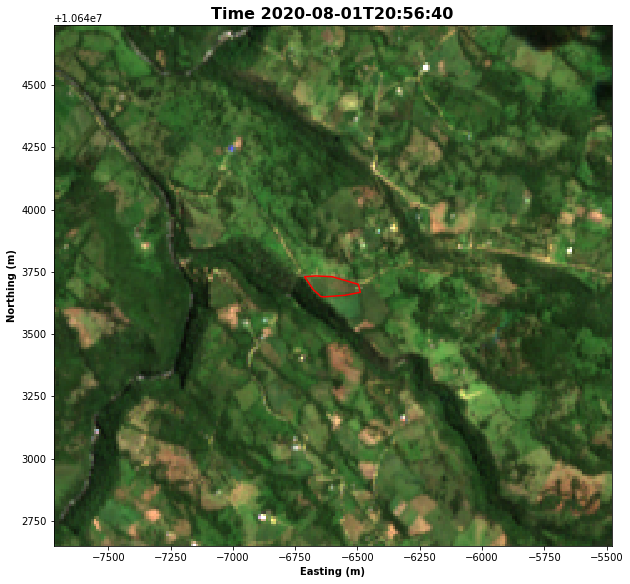

In [174]:
# Seleccionar indice de tiempo en la consulta
time_index = 0

# Selección de la combinación de bandas
bands = ["red", "green", "blue"]


# Etiqueta del tiempo de la imágen
time_string = str(dataset.time.isel(time=time_index).values).split('.')[0]  

dataset[bands].isel(time=time_index).to_array().plot.imshow(vmin=0,vmax=1500,figsize=(10,10))

# COnfiguración de etiquetas y ejes
ax = plt.gca()

df_polygon.boundary.plot(ax=ax,color='red')


ax.set_title(f"Time {time_string}", fontweight='bold', fontsize=16)
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold')

# Desplegar imagen
plt.show()

##### Imprimir la "banda" SCL

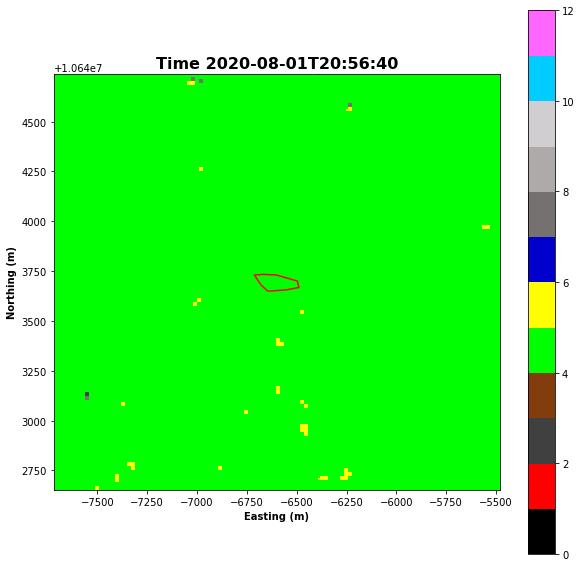

In [175]:
# Selección del periodo de tiempo (0...N)
# Selección combinación de bandas
bands = ["scl"]

# Formato de timestamp para incluirlo en la imagen
time_string = str(dataset.time.isel(time=time_index).values).split('.')[0]  

cmap = colors.ListedColormap(['#000000', '#fe0000','#404040', '#833d0c', '#00ff01', '#ffff01', '#0000cc', '#757170', '#aeaaa9', '#d0ced0', '#00ccff', '#ff66ff'])
boundaries = list(range(13))
norm = colors.BoundaryNorm(boundaries, cmap.N)


dataset[bands].isel(time=time_index).to_array().plot(figsize=(10,10), cmap=cmap, norm= norm)

# Obtener ejes y etiquetas
ax = plt.gca()

# Pintar polígono en la imagen en true color generada por el datacube
df_polygon.boundary.plot(ax=ax,markersize=20,color='red',marker='o')

ax.set_title(f"Time {time_string}", fontweight='bold', fontsize=16)
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold')

# Guardar imagen
# plt.savefig('foo_cloud_total_2.png')

# Desplegar imagen
plt.show()

![SCL](SCL_classes.png)

# 3. Clasificar el área consultada

#### Cargar el algoritmo clasificado

In [176]:
model_file_path = 'ModeloRF97.joblib'
modeloRF = joblib.load(model_file_path)

#### Se prepara la información para pasarla al clasificador

In [177]:
# Selecionar datos cuyo periodo de tiempo corresponda a 'time_index'
time_slice = dataset.isel(time=time_index)

# Convertir datos a arrays
data_array = time_slice.to_array()

# Transponer el cubo de tal forma que las bandas hagan parte de la tercera dimensión
transposed_data_array = data_array.transpose('y','x','variable')
# transposed_data_array = data_array.transpose('latitude','longitude','variable')
values = transposed_data_array.values 
values = values.reshape(-1, len(dataset.data_vars))

columns = list(dataset.data_vars.keys())
dataframe = pd.DataFrame(values, columns=columns)


In [178]:
dataframe

,coastal_aerosol,red,blue,green,nir,narrow_nir,water_vapour,veg5,veg6,veg7,swir1,swir2,scl
0,167,355,256,526,2498,2389,2591,876,1879,2244,1568,872,4
1,167,239,180,401,2139,1908,2591,605,1437,1760,1201,587,4
2,167,220,150,343,1781,1908,2591,605,1437,1760,1201,587,4
3,167,213,153,286,1593,2298,2591,613,1584,1971,1180,558,4
4,167,185,110,288,1094,2298,2591,613,1584,1971,1180,558,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46811,69,189,147,320,2270,2474,2615,618,1833,2274,1254,576,4
46812,62,215,177,317,2033,2225,2462,579,1591,1968,1209,579,4
46813,62,240,168,305,1982,2225,2462,579,1591,1968,1209,579,4
46814,62,214,152,274,2068,2314,2462,643,1711,2116,1245,586,4


##### Se genera una máscara de nubes

In [179]:
a = (dataset.scl[time_index].values <=10)
b = (dataset.scl[time_index].values >=7)
cloud_shadow_mask = (~(dataset.scl[time_index].values <=3)).astype(int)
cloud_mask = (~np.multiply(a,b)).astype(int)
cloud_shadow_mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

### Prediccion con Random Forest

In [180]:
prediction = modeloRF.predict(dataframe)
prediction = prediction.astype(int)
result = prediction.reshape(dataset.y.size, dataset.x.size)
result = np.multiply(result, cloud_mask)
temporal_mask = (result ==0).astype(int) *10
result = np.add(result, temporal_mask)
result = np.multiply(result, cloud_shadow_mask)
result    

array([[5, 3, 3, ..., 5, 5, 5],
       [3, 3, 3, ..., 5, 5, 5],
       [3, 3, 3, ..., 5, 5, 5],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

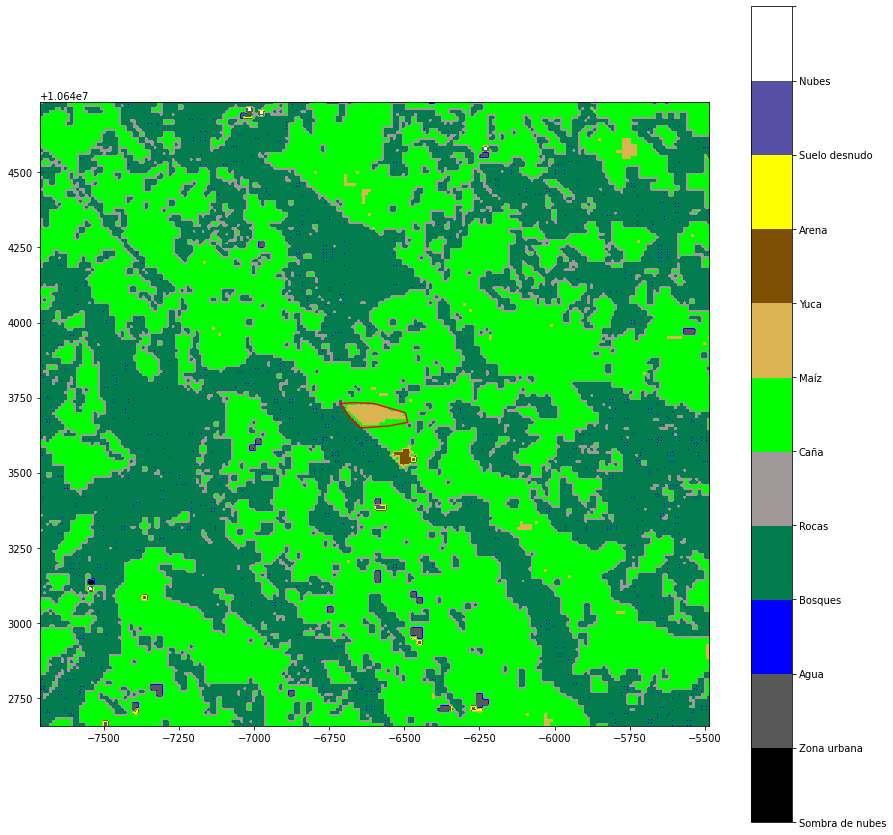

In [181]:
%matplotlib inline

import matplotlib.colors as colors

cmap = colors.ListedColormap(['#000000', '#595858', '#0000FF', '#037d50', '#a19999', '#00FF00', '#d9b450', '#7d5003', '#fbff00','#5550a3', '#ffffff']) #]), '#2E2B5F'
fig, ax = plt.subplots(figsize=(15,15))
boundaries = list(range(0,12))

norm = colors.BoundaryNorm(boundaries, cmap.N)

df_polygon.boundary.plot(ax=ax,color='red')

extent = [
        min(dataset.x.values), max(dataset.x.values),
        min(dataset.y.values), max(dataset.y.values)
]

im =  ax.imshow(result, cmap=cmap, extent=extent, norm = norm)

cbar = plt.colorbar(im)

cbar.set_ticks(boundaries)

cbar.set_ticklabels(["Sombra de nubes", "Zona urbana", "Agua", "Bosques", "Rocas", "Caña", "Maíz", "Yuca", "Arena", "Suelo desnudo", "Nubes"])

cbar.config_axis

plt.show()